# Setup

In [1]:
import contracts
contracts.disable_all()

In [2]:
import duckietown_world as dw
from duckietown_world.svg_drawing.ipython_utils import ipython_draw_html
import geometry as g
import numpy as np
import networkx as nx
import copy

import sys
from duckietown_uplan.graph_utils.augmentation import GraphAugmenter
from duckietown_uplan.graph_utils.segmentify import get_skeleton_graph

INFO:dt-world:duckietown-world 1.0.19
DEBUG:dt-serialization:Registering class Serializable
DEBUG:dt-serialization:Registering class GenericData
DEBUG:dt-serialization:Registering class Sequence
DEBUG:dt-serialization:Registering class SampledSequence
DEBUG:dt-serialization:Registering class Constant
DEBUG:dt-serialization:Registering class RectangularArea
DEBUG:dt-serialization:Registering class TransformSequence
DEBUG:dt-serialization:Registering class VariableTransformSequence
DEBUG:dt-serialization:Registering class SE2Transform
DEBUG:dt-serialization:Registering class Scale2D
DEBUG:dt-serialization:Registering class Matrix2D
DEBUG:dt-serialization:Registering class SpatialRelation
DEBUG:dt-serialization:Registering class GroundTruth
DEBUG:dt-serialization:Registering class PlacedObject
DEBUG:dt-serialization:Registering class EvaluatedMetric
DEBUG:dt-serialization:Registering class GenericObject
DEBUG:dt-serialization:Registering class Duckie
DEBUG:dt-serialization:Registering cla

In [3]:
dw.logger.setLevel(50)

Better visualization of output

In [4]:
%%html
<style>
pre {line-height: 90%}
</style>

# Road Network
Let's load a map and compute the road network.

In [5]:
m = dw.load_map('4way')

Use the function `get_skeleton_graph`:

In [6]:
sk = get_skeleton_graph(m)
#ipython_draw_html(sk.root2);

In [7]:
import time
def timems():
    return int(round(time.time() * 1000))

## Augment Graph

In [20]:
starttime = timems()
aug_graph = GraphAugmenter.augment_graph(sk.G, num_long=2, num_right=1, num_left=3, lat_dist = 0.05)
endtime = timems()
print(endtime-starttime)

330


## Shortest path example

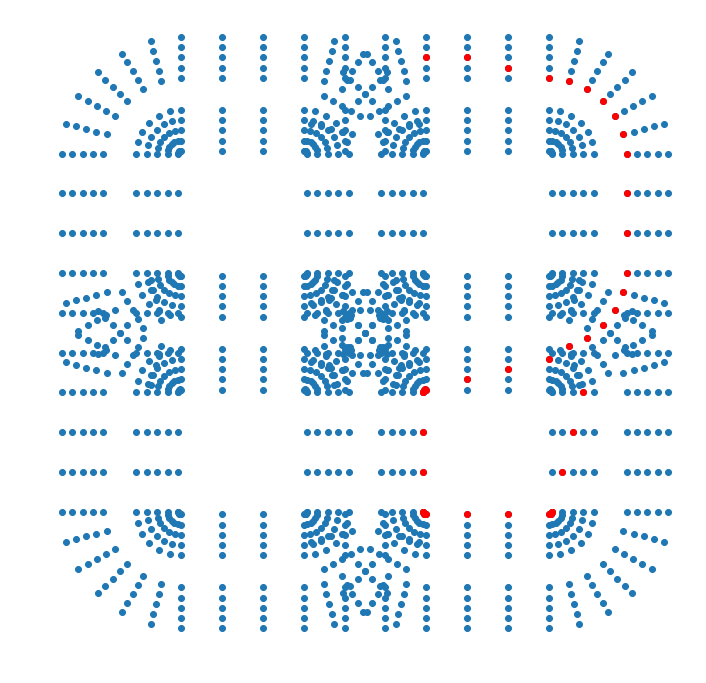

In [21]:
path = nx.shortest_path(aug_graph, source=(229, 0), target=(256, -1), weight='dist')

points_cords = np.vstack([aug_graph.node[x]['point'].p for x in aug_graph])
path_cords = np.vstack([aug_graph.node[x]['point'].p for x in path])

%matplotlib inline

import matplotlib.pyplot as plt
plt.figure(figsize=(12, 12))    
plt.scatter(points_cords[:,0], points_cords[:,1])
plt.scatter(path_cords[:,0], path_cords[:,1], c='r')
plt.axis('off')
plt.show()

## Draw graph with edges (slow)

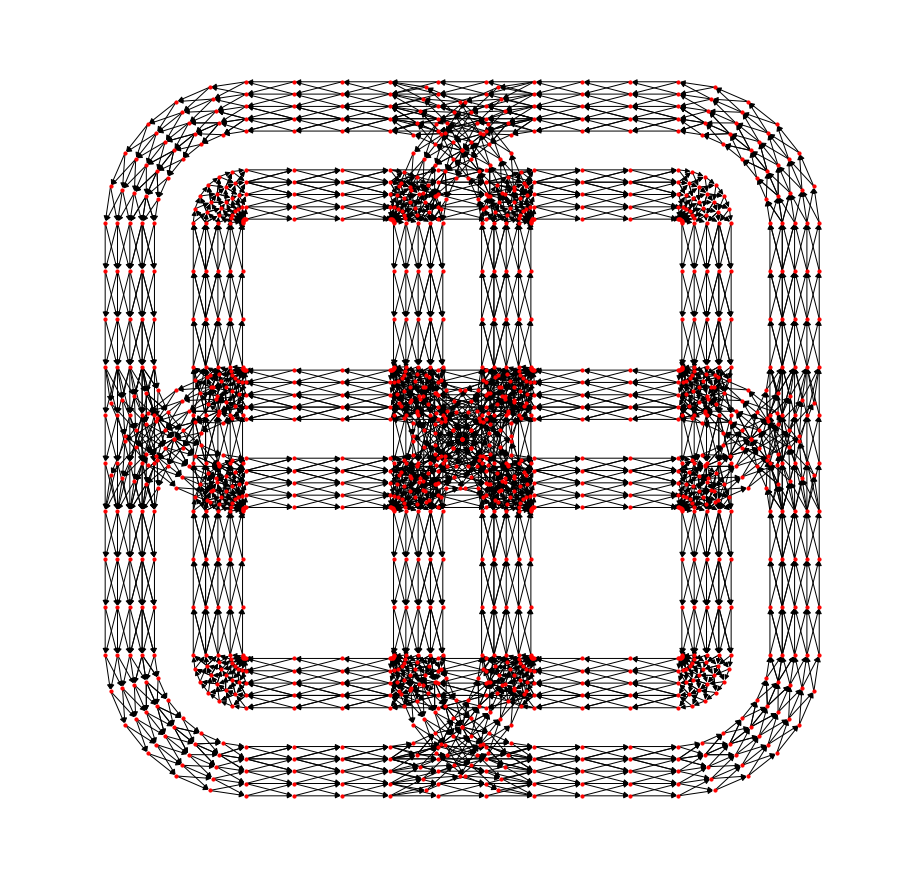

26945


In [22]:
def draw_graph(G0, pos=None):
    import networkx as nx
    from matplotlib import pyplot as plt
    pos = pos or nx.spring_layout(G0)
    plt.figure(figsize=(12, 12))    
    nx.draw(G0,pos,labels={}, node_size=10) # node:node for node in G0.nodes()
    nx.draw_networkx_edge_labels(G0,pos,edge_labels={},font_color='red')
    plt.axis('off')
    plt.show()

%matplotlib inline
starttime = timems()

import geometry as geo
pos = {}
for n in aug_graph:
    q = aug_graph.nodes[n]['point'].as_SE2()
    t, _ = geo.translation_angle_from_SE2(q)
    pos[n] = t
draw_graph(aug_graph, pos=pos)
endtime = timems()
print(endtime-starttime)